In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('..')

In [900]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.measure as measure

from pathlib import Path
from skimage.feature import blob_log
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans

from src.augmentations import RandomCrop
from src.dataset import SartoriusDataset
from src.models import UnetEffNetV2

In [4]:
def min_max_normalize(x):
    return (x - x.min()) / (x.max() - x.min())


def dimension_reduction(x, out_dim=3):
    h, w, dim = x.shape

    x_red = PCA(n_components=out_dim).fit_transform(x.reshape(-1, dim))
    x_red = np.reshape(x_red, (h, w, out_dim))

    return min_max_normalize(x_red)

In [160]:
# def build_model(path, input_shape):
#     model = tf.keras.models.load_model(path)
#     model.layers.pop(0)
    

In [159]:
model = tf.keras.models.load_model('../ueffnet_v2_m_contrastive.h5')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 640, 1) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 320, 24) 216         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 320, 24) 96          stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_swish (Activation)         (None, 256, 320, 24) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [145]:
from src.augmentations import Augmentation


def pad(x, pad_h, pad_w):
    print(x.shape)
    return tf.pad(x, paddings=[[pad_h, pad_h], 
                               [pad_w, pad_w], 
                               [0, 0]])
                               

class Padding(Augmentation):
    def __init__(self, pad_h, pad_w) -> None:
        params = {
            'pad_h': pad_h, 
            'pad_w': pad_w
        }

        super().__init__('Padding', pad, params, apply_mask=False, prob=1.0)

In [169]:
data_dir = Path('../sartorius-cell-instance-segmentation')

# augmentations_val = [
#     Padding(12, 0)
# ]

ds_params = {
    'root_dir': data_dir/'val', 
    'batch_size': 4, 
    'resize_shape': (512, 640),
    'resize_image_only': True,
    # 'augmentations': augmentations_val, 
    'shuffle': False
}

ds = SartoriusDataset(**ds_params)
dataset = ds.dataset
dataset

<BatchDataset shapes: ((None, 512, 640, 1), (None, 520, 704, 1)), types: (tf.float32, tf.int32)>

In [170]:
images, masks = tuple(next(dataset.as_numpy_iterator()))
images.shape, masks.shape

((4, 512, 640, 1), (4, 520, 704, 1))

In [171]:
mask_embs = tf.nn.l2_normalize(model(images), axis=-1).numpy()
masks_vis = np.array([dimension_reduction(emb) for emb in mask_embs])

mask_embs.shape, masks_vis.shape

((4, 512, 640, 8), (4, 512, 640, 3))

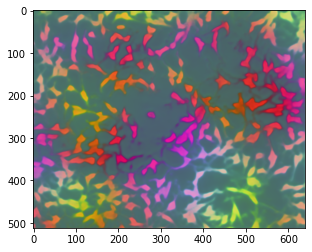

In [15]:
plt.imshow(masks_vis[2])

In [629]:
x = mask



(520, 704)

In [630]:
y_coords

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00192678, 0.00192678, 0.00192678, ..., 0.00192678, 0.00192678,
        0.00192678],
       [0.00385356, 0.00385356, 0.00385356, ..., 0.00385356, 0.00385356,
        0.00385356],
       ...,
       [0.99614644, 0.99614644, 0.99614644, ..., 0.99614644, 0.99614644,
        0.99614644],
       [0.9980732 , 0.9980732 , 0.9980732 , ..., 0.9980732 , 0.9980732 ,
        0.9980732 ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]], dtype=float32)

In [868]:
def cluster_agglo(x):
    params = {
        'n_clusters': None, 
        'affinity': 'cosine', 
        'linkage': 'average', 
        'distance_threshold': 0.4
    }

    # def compute_coord_grids():
    #     x_coords = np.arange(x.shape[1], dtype=np.float32) / (x.shape[1] - 1)
    #     y_coords = np.arange(x.shape[0], dtype=np.float32) / (x.shape[0] - 1)

    #     x_coords = np.repeat(x_coords[None, :], x.shape[0], axis=0)
    #     y_coords = np.repeat(y_coords[:, None], x.shape[1], axis=1)

    #     return x_coords, y_coords

    # x_coords, y_coords = compute_coord_grids()
    # x_cl = np.concatenate((x, x_coords[..., None], y_coords[..., None]), axis=-1)
    # x_cl = np.reshape(x_cl, (-1, x_cl.shape[-1]))

    # print(x_cl.shape)

    x_cl = np.reshape(x, (-1, x.shape[-1]))

    clusters = AgglomerativeClustering(**params).fit_predict(x_cl)
    labels = np.unique(clusters)

    return clusters, labels


def cluster_kmeans(x, n_clusters):
    # def compute_coord_grids():
    #     x_coords = np.arange(x.shape[1], dtype=np.float32) / (x.shape[1] - 1)
    #     y_coords = np.arange(x.shape[0], dtype=np.float32) / (x.shape[0] - 1)

    #     x_coords = np.repeat(x_coords[None, :], x.shape[0], axis=0)
    #     y_coords = np.repeat(y_coords[:, None], x.shape[1], axis=1)

    #     return x_coords, y_coords

    # x_coords, y_coords = compute_coord_grids()
    # x_cl = np.concatenate((x, x_coords[..., None], y_coords[..., None]), axis=-1)
    # x_cl = np.reshape(x_cl, (-1, x_cl.shape[-1]))
    x_cl = np.reshape(x, (-1, x.shape[-1]))
    
    return KMeans(n_clusters=n_clusters).fit_predict(x_cl)


# def compute_instance_mask(x_emb):
#     x_ds = cv2.resize(x_emb, (160, 128))
#     x_ins, _ = cluster_agglo(x_ds)
#     x_ins = np.reshape(x_ins, x_ds.shape[:2])

#     return x_ins

#     mask = cv2.resize(x_ins.astype(np.uint16), (704, 520), 
#                       interpolation=cv2.INTER_CUBIC)

#     return mask


In [926]:
def postprocess_mask(mask):
    def filter_contours(contours):
        return [c for c in contours 
                if 2 < cv2.contourArea(c) < 1000]

    def compute_poly_mask(contours):
        mask_poly = np.zeros_like(mask, dtype=np.int32)

        for idx, con in enumerate(contours):
            cv2.fillPoly(mask_poly, [con], idx + 1)

        return mask_poly

    def compute_filtered_mask(poly_mask, label_mask):
        mask_filtered = np.zeros_like(mask, dtype=np.int32)

        poly_labels = np.unique(poly_mask)
        it = iter(range(1, len(poly_labels)))
        
        for idx in poly_labels[1:]:
            intersection = (poly_mask == idx) & label_mask

            if intersection.sum() > 40:
                fraction = intersection.sum() / (poly_mask == idx).sum()

                if fraction > 0.8:
                    # intersection_eroded = cv2.erode(intersection.astype(np.uint8), np.ones(9))

                    # if intersection_eroded.sum() / intersection.sum() > 0.2:

                    # if intersection.sum() > 10:
                        mask_filtered[intersection] = next(it)

        return mask_filtered

    labels, counts = np.unique(mask, return_counts=True)

    background_label = labels[np.argmax(counts)]

    # Removing background label 
    labels = labels[np.where(labels != background_label)]

    proc_mask = np.zeros_like(mask, dtype=np.int32)

    it = iter(range(1, int(1e4)))

    for label in labels:
        label_mask = mask == label

        contours, _ = cv2.findContours((label_mask == 1).astype(np.uint8), 
                                       cv2.RETR_TREE, 
                                       cv2.CHAIN_APPROX_SIMPLE)

        contours = filter_contours(contours)
        poly_mask = compute_poly_mask(contours)
        # filtered_mask = compute_filtered_mask(poly_mask, label_mask)

        for idx in np.unique(poly_mask)[1:]:
            proc_mask[poly_mask == idx] = next(it)
        
    return proc_mask


def postprocess_mask_v2(mask):
    def erode_mask(mask):
        return cv2.erode(mask.astype(np.uint8), np.ones(3))

    labels, counts = np.unique(mask, return_counts=True)

    background_label = labels[np.argmax(counts)]

    # Removing background label 
    labels = labels[np.where(labels != background_label)]

    proc_mask = np.zeros_like(mask, dtype=np.int32)

    it = iter(range(1, int(1e4)))

    for label in labels:
        sub_labels_mask = measure.label(erode_mask(mask == label))

        for sub_label in np.unique(sub_labels_mask)[1:]:
            proc_mask[sub_labels_mask == sub_label] = next(it)

    return proc_mask


def compute_instance_mask(x_emb):
    x_ds = cv2.resize(x_emb, (160, 128))
    x_ins, _ = cluster_agglo(x_ds)
    x_ins = np.reshape(x_ins, x_ds.shape[:2])

    x_ins = postprocess_mask_v2(x_ins)

    mask = cv2.resize(x_ins.astype(np.uint16), (704, 520), 
                      interpolation=cv2.INTER_NEAREST)

    return mask

In [944]:
idx = 3

mask = compute_instance_mask(mask_embs[idx])
mask.shape

(520, 704)

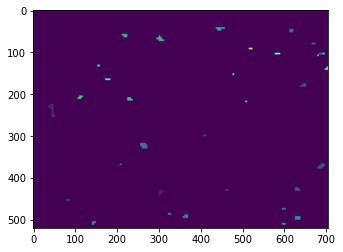

In [945]:
plt.imshow(mask)

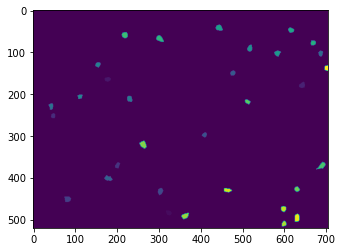

In [946]:
plt.imshow(masks[idx])

In [68]:
# TODO: tune clustering algorithm
# TODO: for each image background class should be 0
# TODO: split cells inside an instance if measure.label applicable
# TODO: compute metric
# TODO: make first submission